**Last Updated**: *7 May 2025*

**CNN Auto-Encoder**

In [ ]:
# === Modules ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch

In [3]:
# === Load data ===
normal_data = np.load('train_non_CD_features2.npy')        
cd_data = np.load('train_CD_features2.npy')                

normal_data = np.delete(normal_data, [2, 3, 6], axis=1)
cd_data = np.delete(cd_data, [2, 3, 6], axis=1)

normal_tensor = torch.tensor(normal_data, dtype=torch.float32)
cd_tensor = torch.tensor(cd_data, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(normal_tensor), batch_size=32, shuffle=True)

In [4]:
# === Functions: Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x[:, :, :50, :50]


In [5]:
# === Set device ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

Device will run on cuda


In [39]:
# === Train the model ===
model = Autoencoder().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.6f}")

Training...
Epoch 1: Loss = 0.404356
Epoch 2: Loss = 0.345797
Epoch 3: Loss = 0.343626
Epoch 4: Loss = 0.342754
Epoch 5: Loss = 0.342190
Epoch 6: Loss = 0.341668
Epoch 7: Loss = 0.341158
Epoch 8: Loss = 0.340730
Epoch 9: Loss = 0.340279
Epoch 10: Loss = 0.339921


In [63]:
# === Compute reconstruction error ===
model.eval()
with torch.no_grad():
    normal_tensor = normal_tensor.to(device)
    recon_normal = model(normal_tensor)
    normal_errors = torch.mean((normal_tensor - recon_normal) ** 2, dim=[1, 2, 3]).cpu().numpy()

with torch.no_grad():
    recon_cd = model(cd_tensor)
    cd_errors = torch.mean((cd_tensor - recon_cd) ** 2, dim=[1, 2, 3]).cpu().numpy()

all_errors = np.concatenate([normal_errors, cd_errors])


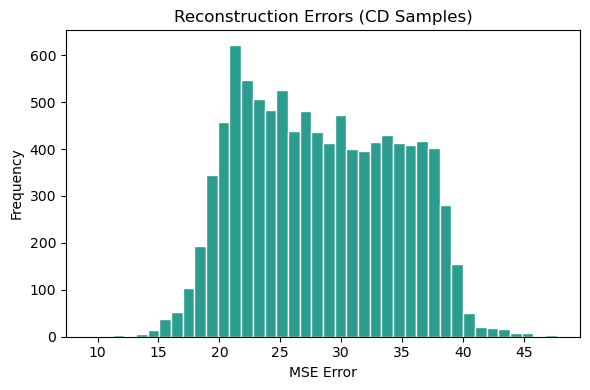

In [ ]:
# === Plot normal error histogram ===
plt.figure(figsize=(6, 4))
plt.hist(normal_errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

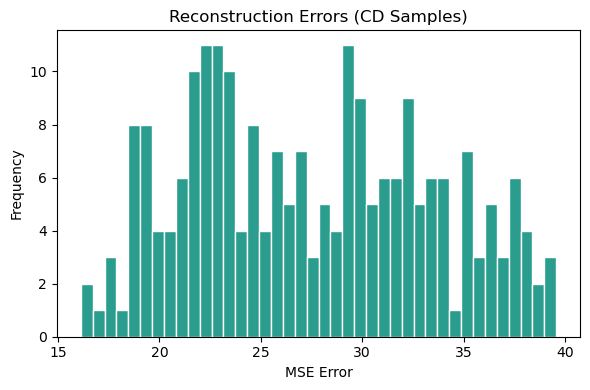

In [66]:
# === Plot CD error histogram ===
plt.figure(figsize=(6, 4))
plt.hist(cd_errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# === Plot normal error histogram ===
plt.figure(figsize=(6, 4))
plt.hist(normal_errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

In [86]:
# === Flag anomalies with threshold ===
threshold = np.percentile(cd_errors, 25)
anomalies = cd_errors > threshold
print(f"Threshold (25th percentile): {threshold:.6f}")
print(f"Detected {np.sum(anomalies)} anomalies out of {len(cd_errors)} CD samples.")
normals = normal_errors > threshold
print(f"Detected {np.sum(normals)} anomalies out of {len(normal_errors)} non-CD samples.")

Threshold (25th percentile): 22.419062
Detected 167 anomalies out of 223 CD samples.
Detected 7817 anomalies out of 9993 non-CD samples.


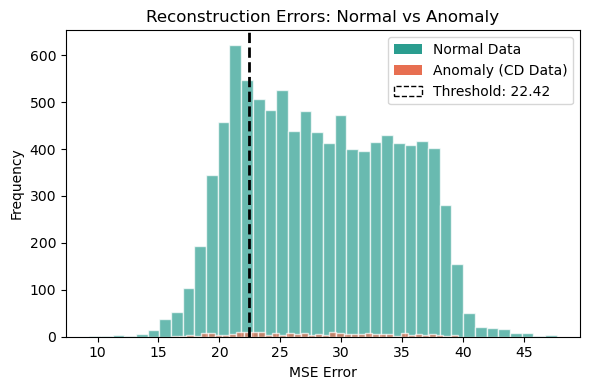

In [84]:
# === Plot histogram with threshold ===
plt.figure(figsize=(6, 4))

plt.hist(normal_errors, bins=40, color='#2A9D8F', edgecolor='white', alpha=0.7, label='Normal Data')
plt.hist(cd_errors, bins=40, color='#E76F51', edgecolor='white', alpha=0.7, label='Anomaly (CD Data)')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2f}')

legend_elements = [
    Patch(facecolor='#2A9D8F', label='Normal Data'),
    Patch(facecolor='#E76F51', label='Anomaly (CD Data)'),
    Patch(facecolor='none', edgecolor='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
]
plt.legend(handles=legend_elements)

plt.title("Reconstruction Errors: Normal vs Anomaly")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()

In [103]:
# === Test data ===
unseen_CD_data = np.load("test_CD_features2.npy")
unseen_CD_data = np.delete(unseen_CD_data, [2, 3, 6], axis=1)
unseen_CD_tensor = torch.tensor(unseen_CD_data, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    recon_unseen_CD = model(unseen_CD_tensor)
    errors_unseen_CD = torch.mean((unseen_CD_tensor - recon_unseen_CD) ** 2, dim=[1, 2, 3]).cpu().numpy()

anomalies_CD = errors_unseen_CD > threshold
print(f"Detected {np.sum(anomalies_CD)} anomalies out of {len(errors_unseen_CD)} CD samples.")

unseen_normal_data = np.load("test_non-CD_features2.npy")
unseen_normal_data = np.delete(unseen_normal_data, [2, 3, 6], axis=1)
unseen_normal_tensor = torch.tensor(unseen_normal_data, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    recon_unseen_normal = model(unseen_normal_tensor)
    errors_unseen_normal = torch.mean((unseen_normal_tensor - recon_unseen_normal) ** 2, dim=[1, 2, 3]).cpu().numpy()

anomalies_normal = errors_unseen_normal > threshold
print(f"Detected {np.sum(anomalies_normal)} anomalies out of {len(errors_unseen_normal)} non-CD samples.")

Detected 52 anomalies out of 68 CD samples.
Detected 486 anomalies out of 508 non-CD samples.


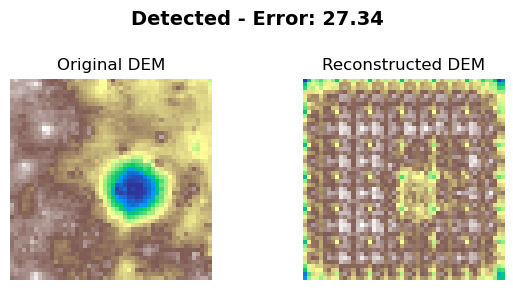

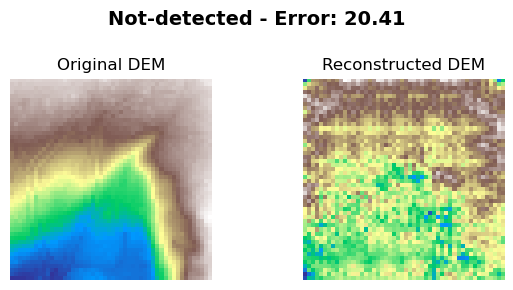

In [104]:
# === Plot one detected anomaly and one not-detected sample ===
anomalous_idx = np.where(anomalies_CD)[0][0]
not_anomalous_idx = np.where(~anomalies_CD)[0][0]

for idx, label in zip([anomalous_idx, not_anomalous_idx], ['Detected', 'Not-detected']):
    error_value = errors_unseen_CD[idx]
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"{label} - Error: {error_value:.2f}", fontsize=14, fontweight='bold')
    axes[0].imshow(unseen_CD_tensor[idx][0].cpu(), cmap='terrain')
    axes[0].set_title("Original DEM")
    axes[1].imshow(recon_unseen_CD[idx][0].cpu(), cmap='terrain')
    axes[1].set_title("Reconstructed DEM")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
    plt.close()
